<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - PyTorch Classification <br>
<font color=696880 size=4>
    Javad Hezareh 
    
    
____


### Full Name : Arshia Dadras
### Student Number : 99109109
___

# Problem
This assignment uses PyTorch to build and implement a MLP model for solving a classification problem. Our goal is to classify galaxy images into 4 classes: ellipticals, lenticulars, spirals, and irregulars. We will use [EFIGI](https://www.astromatic.net/projects/efigi/) dataset which contains 4458 images.

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################

from PIL import Image
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns

In [2]:
def to_numpy(x):
    if torch.cuda.is_available():
        return x.detach().cpu().numpy()
    return x.detach().numpy()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(8569)
device

device(type='cpu')

# Prepare and Visualize Data (10 Points)

Run the following cell to download dataset. `prepare_data` will return a pandas dataframe which contains three columns. `name` is the name of image that you can find that in `./efigi-1.6/png`, `class_name` is the type of galaxy in that image and `class_label` is a numerical label for this class.

In [3]:
# run this cell to download and prepare data
from data_utils import download_data, prepare_data

download_data()
df = prepare_data('./efigi-1.6/EFIGI_attributes.txt')

df.head()

,name,class_name,class_label
0,PGC0000212,Spirals,2
1,PGC0000218,Spirals,2
2,PGC0000243,Lenticulars,1
3,PGC0000255,Spirals,2
4,PGC0000281,Spirals,2


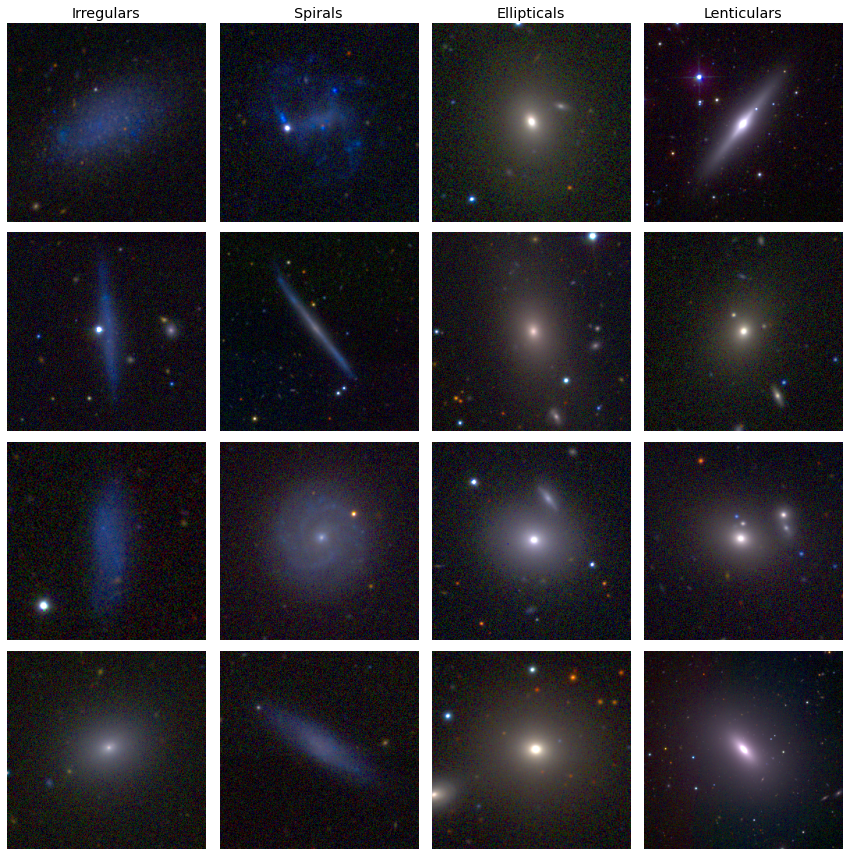

In [4]:
##############################################################
##            Visualize 4 sample from each class            ##
##                        Your Code                         ##
##############################################################

plt.figure(figsize=(12,12))
for i, class_name in enumerate(set(df['class_name'])):
    for j, name in enumerate(np.random.choice(df[df['class_name'] == class_name]['name'], 4)):
        plt.subplot(4, 4, 4 * j + i + 1)
        if j == 0:
            plt.title(class_name)
            
        img = Image.open(f'efigi-1.6/png/{name}.png')
        plt.imshow(img)
        plt.axis('off')
plt.tight_layout()

# Define Dataset (20 Points)

In [5]:
###############################################################
##        Write your dataset class for loading images        ##
##                        Your Code                          ##
###############################################################

import os
from torchvision.io import read_image

class GalaxyDataset(Dataset):
    def __init__(self, img_labels, img_dir, transforms=None, weights=None):
        if weights:
            self.indexes = list(WeightedRandomSampler(weights, len(weights)))
        else:
            self.indexes = list(range(len(img_labels)))
        self.img_labels = img_labels
        self.img_dir = img_dir
        self.transforms = transforms

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        idx = self.indexes[idx]
        image = Image.open(os.path.join(self.img_dir, f'{self.img_labels[idx][0]}.png'))
        label = self.img_labels[idx][1]
        if self.transforms:
            image = self.transforms(image)
        return image, label

# Define Model (20 Points)

In [6]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################

class MLP(nn.Module):
    def __init__(self, input_size, output_size, layers=[]):
        super().__init__()
        self.layers = nn.Sequential(nn.Flatten())
        
        last_layer = input_size
        for layer in layers:
            self.layers.append(nn.Linear(last_layer, layer))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.BatchNorm1d(layer))
            last_layer = layer
            
        self.layers.append(nn.Linear(last_layer, output_size))
        self.layers.append(nn.Softmax(1))

    def forward(self, x):
        return self.layers(x)

# Train Model (30 Points)

In [7]:
input_size = 3 * 255 * 255
# hidden_layers = [64, 64, 32]
hidden_layers = [128, 128, 64, 16]
# hidden_layers = [32, 16, 16]
# hidden_layers = [128, 32, 16]
# hidden_layers = [128, 64, 64]
weighted_train = True
num_classes = 4
train_ratio = .7
batch_size = 128
num_epochs = 10
learning_rate = 1e-3
# learning_rate = 1e-4
img_dir = 'efigi-1.6/png'

In [8]:
train_size = int(train_ratio * len(df))
test_size = len(df) - train_size
train_data, test_data = random_split(df.drop(['class_name'], axis=1).values, [train_size, test_size])

In [9]:
######################################################################
##        Instantiate model, define hyper parameters, optimizer,    ##
##        loss function and etc                                     ##
######################################################################

train_labels = list(df.values[train_data.indices, 2])
train_bincount = torch.bincount(torch.tensor(train_labels))
train_weights = [1 / train_bincount[label] for label in train_labels]

train_dataset = GalaxyDataset(train_data, img_dir, transforms.ToTensor())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = GalaxyDataset(test_data, img_dir, transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=len(test_data))

criterion = nn.CrossEntropyLoss()
model = MLP(input_size, num_classes, hidden_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
def get_accuracy(model, data_loader):
    model.eval()
    correct, total = 0, 0
    for X, y in data_loader:
        y_pred = torch.argmax(model(X), axis=1)
        correct += to_numpy(sum(y == y_pred))
        total += len(X)
    return correct / total * 100

In [11]:
##############################################################
##          Plot metrics graph for different epochs         ##
##                        Your Code                         ##
##############################################################

print(f'Training started...')

model_loader = train_loader
for epoch in range(1, num_epochs+1):
    print(40 * '-')
    print(f'Epoch %{len(str(num_epochs))}d/{num_epochs}:' % epoch)
    
    if weighted_train:
        weighted_train_dataset = GalaxyDataset(train_data, img_dir, transforms.ToTensor(), train_weights)
        model_loader = DataLoader(weighted_train_dataset, batch_size=batch_size, shuffle=True)
    
    current_loss = 0
    for batch, (X, y) in enumerate(model_loader, 1):
        optimizer.zero_grad()
        
        y_pred = model(X)
        loss = criterion(y_pred, y)
        
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
        if batch % 5 == 0:
            print(f'\tLoss after batch %{len(str(len(model_loader)))}d/{len(model_loader)}: %.5f'
                  % (batch, current_loss / batch))
            
    print('\tFinal loss: %.5f' % (current_loss / len(model_loader)))
            
print(40 * '-')
print('Training process has finished!\n')
print(f'Final accuracy on train set: {get_accuracy(model, train_loader):.2f}%')

Training started...
----------------------------------------
Epoch  1/10:
	Loss after batch  5/25: 1.29435
	Loss after batch 10/25: 1.24350
	Loss after batch 15/25: 1.21772
	Loss after batch 20/25: 1.19986
	Loss after batch 25/25: 1.18471
	Final loss: 1.18471
----------------------------------------
Epoch  2/10:
	Loss after batch  5/25: 1.08031
	Loss after batch 10/25: 1.06105
	Loss after batch 15/25: 1.04666
	Loss after batch 20/25: 1.03182
	Loss after batch 25/25: 1.01835
	Final loss: 1.01835
----------------------------------------
Epoch  3/10:
	Loss after batch  5/25: 0.93694
	Loss after batch 10/25: 0.93551
	Loss after batch 15/25: 0.93215
	Loss after batch 20/25: 0.91990
	Loss after batch 25/25: 0.91231
	Final loss: 0.91231
----------------------------------------
Epoch  4/10:
	Loss after batch  5/25: 0.85850
	Loss after batch 10/25: 0.85936
	Loss after batch 15/25: 0.85227
	Loss after batch 20/25: 0.84592
	Loss after batch 25/25: 0.84312
	Final loss: 0.84312
--------------------

# Test Model (20)

Accuracy on test set: 80.27%
F1 score on test set: 0.5783


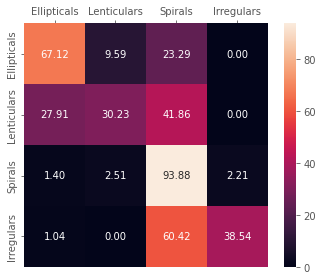

In [12]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

print(f'Accuracy on test set: {get_accuracy(model, test_loader):.2f}%')

class_names = [df[df['class_label'] == label].values[0][1] for label in range(num_classes)]

for X_test, y_test in test_loader:
    y_pred = torch.argmax(model(X_test), axis=1)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print('F1 score on test set: %.4f' % f1)
    confusion = confusion_matrix(y_test, y_pred, normalize='true')

    plt.figure(figsize=(5,4))
    ax = sns.heatmap(confusion * 100, annot=True, fmt='.2f', square=True,
                     xticklabels=class_names, yticklabels=class_names)
    ax.xaxis.tick_top()
plt.tight_layout()

In [13]:
y_test = np.array(test_dataset.img_labels)[:, -1]
random_pred = list(WeightedRandomSampler([1, 1, 1, 1], len(test_dataset)))
weighted_random_pred = list(WeightedRandomSampler(train_bincount, len(test_dataset)))

random_accuracy = sum(random_pred == y_test) / len(y_test)
weighted_random_accuracy = sum(weighted_random_pred == y_test) / len(y_test)
max_occurrence_accuracy = sum(int(torch.argmax(train_bincount)) == y_test) / len(y_test)

print(f'Random prediction accuracy: {100 * random_accuracy:.2f}%')
print(f'Weighted random prediction accuracy: {100 * weighted_random_accuracy:.2f}%')
print(f'Maximum occurrence prediction accuracy: {100 * max_occurrence_accuracy:.2f}%')

Random prediction accuracy: 26.98%
Weighted random prediction accuracy: 59.04%
Maximum occurrence prediction accuracy: 74.51%
